In [1]:
import time
start_time = time.time()
import os
HOME = os.environ['HOME']
# os.chdir(f'{HOME}/desktop/LTT1445_fits_files/Test/Tes2/Tes3/Tes4')
# os.chdir(f'{HOME}/desktop/LTT1445_fits_files/Test/Tes2/Tes3')                    #2nd epoch
os.chdir(f'{HOME}/desktop/LTT1445_fits_files/Test/Tes2')                         #1st epoch

In [2]:
import joblib
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import mad_std, sigma_clip
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import warnings
warnings.filterwarnings("ignore")

import exoplanet as xo

from arctor3 import Arctor, info_message

In [3]:
transit1 = [0,512,300,513]
transit2 = [0,512,178,220]
transit3 = [0,512,150,180]

In [4]:
def instantiate_arctor(planet_name, transit, data_dir, working_dir, file_type):
    planet = Arctor(
        planet_name=planet_name,
        data_dir=data_dir,
        working_dir=working_dir,
        file_type=file_type)

    joblib_filename = f'{planet_name}_savedict.joblib.save'
    joblib_filename = f'{working_dir}/{joblib_filename}'
    if os.path.exists(joblib_filename):
        info_message('Loading Data from Save File')
        planet.load_data(joblib_filename)
    else:
        info_message('Loading New Data Object')
        planet.load_data(transit)

    return planet

def create_raw_lc_stddev(planet):
    ppm = 1e6
    phot_vals = planet.photometry_df
    lc_std_rev = phot_vals.iloc[planet.idx_rev].std(axis=0)                
    lc_std_fwd = phot_vals.iloc[planet.idx_fwd].std(axis=0)                

    lc_med_rev = np.median(phot_vals.iloc[planet.idx_rev], axis=0)
    lc_med_fwd = np.median(phot_vals.iloc[planet.idx_rev], axis=0)

    lc_std = np.mean([lc_std_rev, lc_std_fwd], axis=0)
    lc_med = np.mean([lc_med_rev, lc_med_fwd], axis=0)

    return lc_std / lc_med * ppm

In [5]:
plot_verbose = False
save_now = False
planet_name = 'PlanetName'
file_type = 'flt.fits'

HOME = os.environ['HOME']
# base_dir = os.path.join(HOME, 'path', 'to', 'base')
# data_dir = os.path.join(base_dir, 'path', 'to', 'data')
# data_dir = os.path.join(data_dir, 'HST', 'FLTs')
# working_dir = os.path.join(base_dir, 'path', 'to', 'savefiles')
# base_dir = os.path.join(HOME, 'desktop', 'LTT1445_fits_files', 'Test', 'Tes2', 'Tes3')        #2nd epoch
base_dir = os.path.join(HOME, 'desktop', 'LTT1445_fits_files', 'Test', 'Tes2')                #1st epoch
data_dir = os.path.join(base_dir)
data_dir = os.path.join(data_dir)
working_dir = os.path.join(base_dir)

In [6]:
transit = transit1
planet = instantiate_arctor(planet_name, transit, data_dir, working_dir, file_type)
print(planet)

[INFO] Initializing Instance of the `Arctor` Object
[INFO] Loading New Data Object
[INFO] Loading Fits Files


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 87.01it/s]


[INFO] Creating New Flux/Error/Time Attributes


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 56.06it/s]


[INFO] Found 94 flt.fits files


In [7]:
planet.clean_cosmic_rays()
planet.calibration_trace_location()
planet.identify_trace_direction()
planet.simple_phots()
planet.center_all_traces()
planet.fit_trace_slopes()
planet.compute_sky_background(subpixels=32)
planet.compute_columnwise_sky_background()

[INFO] Flagging Cosmic Rays using `Temporal Simple` Technique


100%|█████████████████████████████████████████████████████████████████████████████████| 213/213 [00:12<00:00, 17.73it/s]


[INFO] Cosmic Ray Mask Creation Took 12.017797946929932 seconds
None
[INFO] Calibration the Median Trace Location
[INFO] Cubic Spline Interpolating the Median Trace Location
[INFO] Calibration the Per Image Trace Location


100%|█████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 1097.23it/s]


[INFO] Identifying Trace Direction per Image


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 670.47it/s]


[INFO] Computing the Center of the Trace


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [01:03<00:00,  1.47it/s]


[INFO] Fitting a slope to the Center of the Trace


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 123.86it/s]


In [8]:
# Set up the list of aperture widths and heights to search
min_aper_width = 1
max_aper_width = 100
min_aper_height = 1
max_aper_height = 100

aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)

In [9]:
planet.do_multi_phot(aper_widths, aper_heights)
print("code took", (time.time()-start_time)/60, "minutes")

[INFO] Beginning Multi-Aperture Photometry
[INFO] Creating Apertures


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 71.50it/s]

[INFO] Configuing Photoutils.Aperture_Photometry
[INFO] Computing Aperture Photometry per Image


[INFO] Aperture Photometry per Image took 382.9222004413605 seconds for 41454 apertures.
[INFO] Restructuring Aperture Photometry into DataFrames
    aperture_sum_1x1  aperture_sum_6x1  aperture_sum_11x1  aperture_sum_16x1  \
0       6.623312e+06      6.731760e+06       6.831949e+06       6.925911e+06   
1       6.798609e+06      6.937614e+06       7.041327e+06       7.143942e+06   
2       6.673027e+06      6.783864e+06       6.884207e+06       6.978811e+06   
3       6.820079e+06      6.953671e+06       7.056537e+06       7.160818e+06   
4       6.725468e+06      6.831667e+06       6.933143e+06       7.029653e+06   
..               ...               ...                ...                ...   
89      6.459691e+06      6.588050e+06       6.695673e+06       6.801059e+06   
90      6.235696e+06      6.346934e+06       6.452752e+06       6.548807e+06   
91      6.444365e+06      6.579563e+06       6.686831e+06       6.791377e+06   
92      6.260931e+06      6.371929e+06       6.475150e

In [10]:
planet_coarse_photometry_df = planet.photometry_df.copy()
planet.photometry_df


,aperture_sum_1x1,aperture_sum_6x1,aperture_sum_11x1,aperture_sum_16x1,aperture_sum_21x1,aperture_sum_26x1,aperture_sum_31x1,aperture_sum_36x1,aperture_sum_41x1,aperture_sum_46x1,...,aperture_sum_56x101,aperture_sum_61x101,aperture_sum_66x101,aperture_sum_71x101,aperture_sum_76x101,aperture_sum_81x101,aperture_sum_86x101,aperture_sum_91x101,aperture_sum_96x101,aperture_sum_101x101
0,6.623312e+06,6.731760e+06,6.831949e+06,6.925911e+06,7.015077e+06,7.097961e+06,7.179106e+06,7.263960e+06,7.353034e+06,7.442881e+06,...,2.588753e+07,2.625691e+07,2.662121e+07,2.698460e+07,2.734549e+07,2.770611e+07,2.806942e+07,2.842499e+07,2.873244e+07,2.888234e+07
1,6.798609e+06,6.937614e+06,7.041327e+06,7.143942e+06,7.248603e+06,7.353732e+06,7.456364e+06,7.556277e+06,7.656665e+06,7.757578e+06,...,2.642705e+07,2.679562e+07,2.716322e+07,2.752597e+07,2.788659e+07,2.825034e+07,2.861130e+07,2.897093e+07,2.932667e+07,2.966655e+07
2,6.673027e+06,6.783864e+06,6.884207e+06,6.978811e+06,7.069584e+06,7.157145e+06,7.241133e+06,7.328472e+06,7.418306e+06,7.511363e+06,...,2.595596e+07,2.632120e+07,2.668841e+07,2.705485e+07,2.741970e+07,2.778269e+07,2.814170e+07,2.849161e+07,2.878602e+07,2.890350e+07
3,6.820079e+06,6.953671e+06,7.056537e+06,7.160818e+06,7.265303e+06,7.368217e+06,7.470539e+06,7.572213e+06,7.673297e+06,7.773694e+06,...,2.642021e+07,2.678580e+07,2.715062e+07,2.751674e+07,2.788212e+07,2.824747e+07,2.860912e+07,2.897137e+07,2.933117e+07,2.967224e+07
4,6.725468e+06,6.831667e+06,6.933143e+06,7.029653e+06,7.122571e+06,7.208700e+06,7.292157e+06,7.376166e+06,7.464376e+06,7.555223e+06,...,2.587616e+07,2.624004e+07,2.660391e+07,2.696881e+07,2.733150e+07,2.769223e+07,2.805298e+07,2.840927e+07,2.871883e+07,2.887374e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,6.459691e+06,6.588050e+06,6.695673e+06,6.801059e+06,6.907465e+06,7.013869e+06,7.118557e+06,7.224017e+06,7.326008e+06,7.424432e+06,...,2.638715e+07,2.675100e+07,2.711549e+07,2.748170e+07,2.784679e+07,2.821260e+07,2.857474e+07,2.893344e+07,2.928748e+07,2.963271e+07
90,6.235696e+06,6.346934e+06,6.452752e+06,6.548807e+06,6.640624e+06,6.729923e+06,6.812927e+06,6.891343e+06,6.971333e+06,7.057783e+06,...,2.585071e+07,2.622017e+07,2.658735e+07,2.695339e+07,2.731642e+07,2.767585e+07,2.803088e+07,2.838666e+07,2.871549e+07,2.890164e+07
91,6.444365e+06,6.579563e+06,6.686831e+06,6.791377e+06,6.896592e+06,7.000413e+06,7.103757e+06,7.204852e+06,7.307996e+06,7.410385e+06,...,2.640222e+07,2.677134e+07,2.714194e+07,2.750865e+07,2.787312e+07,2.823812e+07,2.860365e+07,2.896668e+07,2.932491e+07,2.966870e+07
92,6.260931e+06,6.371929e+06,6.475150e+06,6.574486e+06,6.673970e+06,6.762743e+06,6.838551e+06,6.908491e+06,6.986546e+06,7.074427e+06,...,2.582995e+07,2.619252e+07,2.656219e+07,2.693400e+07,2.729786e+07,2.765478e+07,2.800898e+07,2.836735e+07,2.870342e+07,2.888990e+07


In [11]:
coarse_snr_lightcurves = create_raw_lc_stddev(planet)
coarse_min_snr = coarse_snr_lightcurves[coarse_snr_lightcurves.argmin()]
coarse_min_snr_colname = planet.photometry_df.columns[coarse_snr_lightcurves.argmin()]
coarse_min_snr_col = planet.normed_photometry_df[coarse_min_snr_colname]
coarse_temp = coarse_min_snr_colname.split('_')[-1].split('x')
coarse_min_snr_aper_width, coarse_min_snr_aper_height = np.int32(coarse_temp)

In [12]:
info_message(f'Coarse Aperture Photometry Resulted in {coarse_min_snr:0.0f}ppm with '
             f'{coarse_min_snr_aper_width}x{coarse_min_snr_aper_height} aperture size')

[INFO] Coarse Aperture Photometry Resulted in 1121ppm with 101x21 aperture size


In [13]:
fine_buffer = 10
fine_aper_widths = np.arange(coarse_min_snr_aper_width - fine_buffer,
                             coarse_min_snr_aper_width + fine_buffer)

fine_aper_heights = np.arange(coarse_min_snr_aper_height - fine_buffer,
                              coarse_min_snr_aper_height + fine_buffer)

In [14]:
planet.do_multi_phot(fine_aper_widths, fine_aper_heights)

[INFO] Beginning Multi-Aperture Photometry
[INFO] Creating Apertures


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 60.08it/s]


[INFO] Configuing Photoutils.Aperture_Photometry
[INFO] Computing Aperture Photometry per Image
[INFO] Aperture Photometry per Image took 195.60649061203003 seconds for 37600 apertures.
[INFO] Restructuring Aperture Photometry into DataFrames
    aperture_sum_91x11  aperture_sum_92x11  aperture_sum_93x11  \
0         2.615728e+07        2.622103e+07        2.628268e+07   
1         2.664949e+07        2.671628e+07        2.678301e+07   
2         2.620640e+07        2.626968e+07        2.632906e+07   
3         2.664178e+07        2.670908e+07        2.677645e+07   
4         2.613285e+07        2.619765e+07        2.626115e+07   
..                 ...                 ...                 ...   
89        2.653047e+07        2.659691e+07        2.666326e+07   
90        2.603666e+07        2.610252e+07        2.616813e+07   
91        2.656125e+07        2.662848e+07        2.669526e+07   
92        2.601447e+07        2.608120e+07        2.614765e+07   
93        2.650380e+07        2

[INFO] Adding column aperture_sum_102x16 to self.photometry_df
[INFO] Adding column aperture_sum_103x16 to self.photometry_df
[INFO] Adding column aperture_sum_104x16 to self.photometry_df
[INFO] Adding column aperture_sum_105x16 to self.photometry_df
[INFO] Adding column aperture_sum_106x16 to self.photometry_df
[INFO] Adding column aperture_sum_107x16 to self.photometry_df
[INFO] Adding column aperture_sum_108x16 to self.photometry_df
[INFO] Adding column aperture_sum_109x16 to self.photometry_df
[INFO] Adding column aperture_sum_110x16 to self.photometry_df
[INFO] Adding column aperture_sum_91x17 to self.photometry_df
[INFO] Adding column aperture_sum_92x17 to self.photometry_df
[INFO] Adding column aperture_sum_93x17 to self.photometry_df
[INFO] Adding column aperture_sum_94x17 to self.photometry_df
[INFO] Adding column aperture_sum_95x17 to self.photometry_df
[INFO] Adding column aperture_sum_96x17 to self.photometry_df
[INFO] Adding column aperture_sum_97x17 to self.photometry_df

[INFO] Adding column aperture_sum_97x23 to self.photometry_df
[INFO] Adding column aperture_sum_98x23 to self.photometry_df
[INFO] Adding column aperture_sum_99x23 to self.photometry_df
[INFO] Adding column aperture_sum_100x23 to self.photometry_df
[INFO] Adding column aperture_sum_101x23 to self.photometry_df
[INFO] Adding column aperture_sum_102x23 to self.photometry_df
[INFO] Adding column aperture_sum_103x23 to self.photometry_df
[INFO] Adding column aperture_sum_104x23 to self.photometry_df
[INFO] Adding column aperture_sum_105x23 to self.photometry_df
[INFO] Adding column aperture_sum_106x23 to self.photometry_df
[INFO] Adding column aperture_sum_107x23 to self.photometry_df
[INFO] Adding column aperture_sum_108x23 to self.photometry_df
[INFO] Adding column aperture_sum_109x23 to self.photometry_df
[INFO] Adding column aperture_sum_110x23 to self.photometry_df
[INFO] Adding column aperture_sum_91x24 to self.photometry_df
[INFO] Adding column aperture_sum_92x24 to self.photometry_

[INFO] Adding column aperture_sum_91x30 to self.photometry_df
[INFO] Adding column aperture_sum_92x30 to self.photometry_df
[INFO] Adding column aperture_sum_93x30 to self.photometry_df
[INFO] Adding column aperture_sum_94x30 to self.photometry_df
[INFO] Adding column aperture_sum_95x30 to self.photometry_df
[INFO] Adding column aperture_sum_96x30 to self.photometry_df
[INFO] Adding column aperture_sum_97x30 to self.photometry_df
[INFO] Adding column aperture_sum_98x30 to self.photometry_df
[INFO] Adding column aperture_sum_99x30 to self.photometry_df
[INFO] Adding column aperture_sum_100x30 to self.photometry_df
[INFO] Adding column aperture_sum_101x30 to self.photometry_df
[INFO] Adding column aperture_sum_102x30 to self.photometry_df
[INFO] Adding column aperture_sum_103x30 to self.photometry_df
[INFO] Adding column aperture_sum_104x30 to self.photometry_df
[INFO] Adding column aperture_sum_105x30 to self.photometry_df
[INFO] Adding column aperture_sum_106x30 to self.photometry_df
[

In [15]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [16]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [17]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 531ppm with 110x21 aperture size; with median uncertainties of 188 ppm


In [18]:
data_df = pd.DataFrame()
data_df['flux'] = fine_min_snr_flux.values
data_df['unc'] = fine_min_snr_uncs.values
data_df['times'] = planet.times
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev
# data_df.sort_values('times', inplace=True)
# data_df = data_df.reset_index()
# data_df.drop(['index'], axis=1, inplace=True)
data_df

,flux,unc,times
0,0.999615,0.000190,59483.485144
1,0.999830,0.000186,59483.486024
2,0.999866,0.000190,59483.486904
3,1.000191,0.000186,59483.487783
4,0.999520,0.000189,59483.488663
...,...,...,...
89,1.000687,0.000186,59483.639577
90,1.000626,0.000190,59483.640457
91,1.000983,0.000186,59483.641336
92,1.000168,0.000190,59483.642216


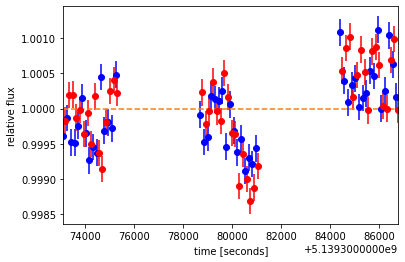

In [19]:
# Compute a limb-darkened light curve using starry
t = data_df['times']*86400
u = []
flux = data_df['flux']
yerr = data_df['unc']
# Note: the `eval` is needed because this is using Theano in
# the background

plt.errorbar(t[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [seconds]")
plt.xlim(t.min(), t.max());

In [20]:
fluxppm = (data_df['flux'] - 1)*1e6

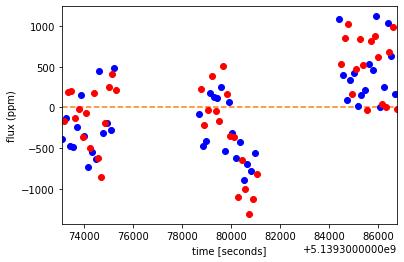

In [21]:
plt.errorbar(t[idx_fwd], fluxppm[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], fluxppm[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("flux (ppm)")
plt.xlabel("time [seconds]")
plt.xlim(t.min(), t.max());

In [22]:
print("code took", (time.time()-start_time)/60, "minutes")

code took 12.128080483277639 minutes


Text(0.5, 0, 'time [seconds]')

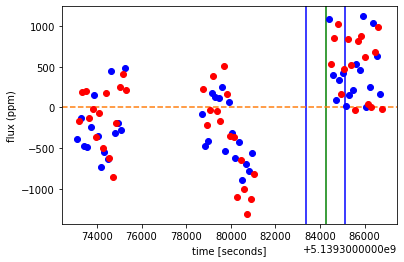

In [23]:
plt.axvline(11145.2654766+t.min(), color = 'g', label = 'axvline - full height') #Middle of transit
plt.axvline(11145.2654766+t.min()+868.32, color = 'b', label = 'axvline - full height')
plt.axvline(11145.2654766+t.min()-868.32, color = 'b', label = 'axvline - full height')
plt.errorbar(t[idx_fwd], fluxppm[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], fluxppm[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("flux (ppm)")
plt.xlabel("time [seconds]")
# plt.xlim(t.min(), t.max());

#It's weird that the third set of data doesn't seem to act like the a-data. I am confuzled

In [24]:
print(t.min())

5139373116.453695


Text(0.5, 0, 'time [seconds]')

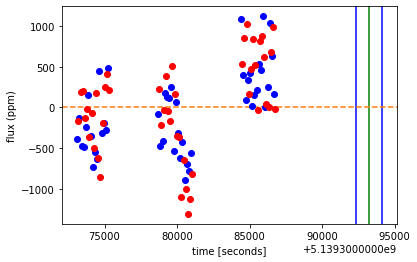

In [25]:
#Ariel's Calculation... This would be great for explaining the data if it were true, but it looks like it doesn't actually
#line up with one transit after the a-data

plt.axvline(20109+t.min(), color = 'g', label = 'axvline - full height') #Middle of transit
plt.axvline(20109+t.min()+868.32, color = 'b', label = 'axvline - full height')
plt.axvline(20109+t.min()-868.32, color = 'b', label = 'axvline - full height')
plt.errorbar(t[idx_fwd], fluxppm[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], fluxppm[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("flux (ppm)")
plt.xlabel("time [seconds]")
# plt.xlim(t.min(), t.max());

Text(0.5, 0, 'time [seconds]')

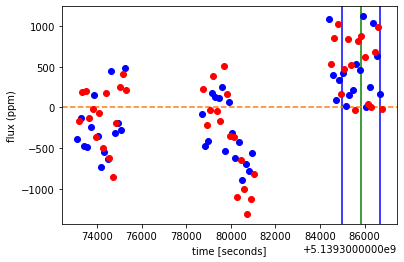

In [26]:
#Attempted 1 period after Ariel's 'a' max

plt.axvline(12718+t.min(), color = 'g', label = 'axvline - full height') #Middle of transit
plt.axvline(12718+t.min()+868.32, color = 'b', label = 'axvline - full height')
plt.axvline(12718+t.min()-868.32, color = 'b', label = 'axvline - full height')
plt.errorbar(t[idx_fwd], fluxppm[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], fluxppm[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("flux (ppm)")
plt.xlabel("time [seconds]")
# plt.xlim(t.min(), t.max());

In [29]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  9 11:49:59 2020

@author: Trevor
"""
import numpy as np
import matplotlib.pyplot as plt
import pickle
from skyfield.api import load
from astropy.time import Time
from barycorrpy import utc_tdb

###########   Working Directory   #####################   


def mjd_bjd(MJD_UTC, flux, flux_err, raDeg, decDeg):
    #fpath='/Users/Trevor/Pythoncode/HST/WASP79/W79_data/'
    fpath = base_dir
#     fileObject = open(fpath+'wlc_extract_out', 'rb')
#     print(fileObject)
#     MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = pickle.load(fileObject)
#     fileObject.close()
    
    stations_url = 'http://celestrak.com/NORAD/elements/science.txt'
    satellites = load.tle_file(stations_url)
    by_name = {sat.name: sat for sat in satellites}
    satellite = by_name['HST']
    print(satellite)
    
    # MJDUTC in correct format for datetime64
    MJDUTC_dt = Time(MJD_UTC, format='mjd', scale='utc')
    yrs =[]
    mths = []
    days = []
    hours = []
    mins = []
    secs = []
    
    for i in np.arange(len(MJDUTC_dt)):
        tt = MJDUTC_dt[i].datetime64
        yrss = tt.astype('datetime64[Y]')
        MM = tt.astype('datetime64[M]')
        mthss = MM-yrss
        dd = tt.astype('datetime64[D]')
        dayss = dd-MM
        hh = tt.astype('datetime64[h]')
        hourss = hh-dd
        mm = tt.astype('datetime64[m]')
        minss = mm-hh
        ss = tt.astype('datetime64[ns]')
        secss = ss-mm
    
        yrs.append(yrss.astype(int)+1970)
        mths.append(mthss.astype(int)+1)
        days.append(dayss.astype(int)+1)
        hours.append(hourss.astype(int))
        mins.append(minss.astype(int))
        secs.append(secss.astype('float')*1e-9)
    
    ts = load.timescale(builtin=True)
    
    tmin = ts.utc(yrs,mths,days,hours,mins,secs) 
    geocentric = satellite.at(tmin)
    subpoint = geocentric.subpoint()
    lati = subpoint.latitude.degrees
    longit = subpoint.longitude.degrees
    elevation = subpoint.elevation.m
    
    for i in np.arange(len(elevation)):
        elevation[i] = int(elevation[i])
        
    JDUTC = MJD_UTC + 2400000.5
    results=[]
    for i in np.arange(len(JDUTC)):
        results.append(utc_tdb.JDUTC_to_BJDTDB(JDUTC[i], ra= raDeg, dec = decDeg, 
                                               lat=lati[i], longi=longit[i], 
                                               alt=elevation[i]))
        if i % 12 == 0:
                print(i)
    
    BJD_TDB=[]
    for i in np.arange(len(results)):
        BJD_TDB.append(float(results[i][0]))
    BJD_TDB = np.array(BJD_TDB)
    
    plt.figure()
    plt.errorbar(BJD_TDB, flux, flux_err, fmt='o', color='k')
    plt.xlabel('Time ($BJD_{TDB}$)')
    plt.ylabel('Flux (e$^-$)')
    plt.show()

#     outpath = fpath                                                                                #Commented this out
#     fileObject = open(outpath+'BJD_TDB', 'wb')
#     pickle.dump([BJD_TDB, flux, flux_err], fileObject)
#     fileObject.close()    
    
    return BJD_TDB

HST catalog #20580 epoch 2022-05-11 12:12:42 UTC
0
12
24
36


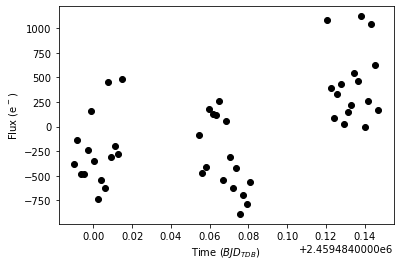

HST catalog #20580 epoch 2022-05-11 12:12:42 UTC
0
12
24
36


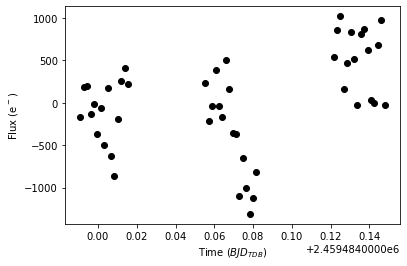

In [30]:
# tbjd = data_df['times']
# tbjd[idx_fwd]
t = data_df['times']
u = []
flux = data_df['flux']
yerr = data_df['unc']

hdul = fits.open(get_pkg_data_filename(glob.glob(base_dir+'/*fits')[1]))
raDeg = hdul[0].header['RA_TARG']
decDeg = hdul[0].header['DEC_TARG']
# timefwd_bjd = mjd_bjd(tbjd[idx_fwd], flux[idx_fwd], yerr[idx_fwd], raDeg, decDeg)
timefwd_bjd = mjd_bjd(t[idx_fwd].reset_index(drop=True), fluxppm[idx_fwd].reset_index(drop=True), yerr[idx_fwd].reset_index(drop=True), raDeg, decDeg)
timerev_bjd = mjd_bjd(t[idx_rev].reset_index(drop=True), fluxppm[idx_rev].reset_index(drop=True), yerr[idx_rev].reset_index(drop=True), raDeg, decDeg)

In [ ]:
# t[idx_fwd].reset_index(drop=True)

Text(0.5, 0, 'time [days]')

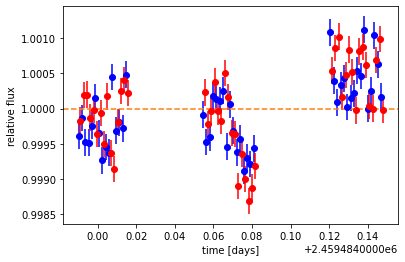

In [31]:
plt.errorbar(timefwd_bjd, flux[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(timerev_bjd, flux[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
# plt.xlim(t.min(), t.max());

In [32]:
if timefwd_bjd.max() < timerev_bjd.max():
    print('rev')

rev


In [33]:
Tcon = 2458412.58159
Period = 3.1239035
Con = 0
for i in range(400):
    if Tcon + Period*i > timefwd_bjd.min():
        if Tcon + Period*i < timerev_bjd.max():
            Con = Tcon + Period*i
            print(Con)

2459484.0804905


Text(0.5, 0, 'time [days]')

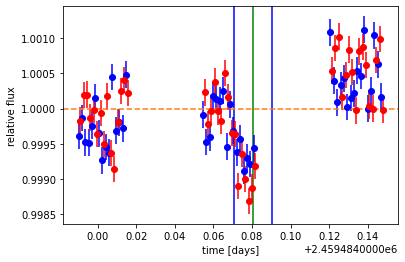

In [34]:
Transit = 0.0201
plt.axvline(Con, color = 'g', label = 'axvline - full height') #Middle of transit
plt.axvline(Con+Transit/2, color = 'b', label = 'axvline - full height')
plt.axvline(Con-Transit/2, color = 'b', label = 'axvline - full height')
plt.errorbar(timefwd_bjd, flux[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(timerev_bjd, flux[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")